# Community Earth System Model (CESM) Plotting tool

This Jupyter notebook can be used to plot CESM outputs directly in the notebook and/or saving the plot to the user's local machine.

The user can upload a single CESM output file in netcdf format. This model file will be in a temporary folder within the vhub environment. The user can run the cells in the notebook individually by clicking on each cell and run the cell with the shift+return or shift+enter option or from the Cell tab Run the indiviadual or all cells option.

The user needs to choose which file to upload. Then enter the desired file name to read in the file below.


In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt              #standard plotting library based upon Matlab functions
import matplotlib.colors as mplc
import datetime

import cartopy.crs as ccrs

#GeoCAT Specific packages
from geocat.viz import util as gvutil

# to display figures in notebook after executing the code.
%matplotlib inline

get_ipython().run_line_magic('matplotlib', 'inline')

# Changing the property for plot font:
plt.rcParams.update({'font.size': 16})



# Defining the path and filenames to read

In [5]:
# Path to the folder containing data
path_to_folder = "/glade/scratch/katec/ghub-data/"

# The CESM data have file names in common except for the beginning 
suffix = 'ts_Amon'

# Variable to visualize
variable = suffix.split('_')[0]

# Files from historical run
file_var_1950_1999 = path_to_folder + suffix + "_CESM2_historical_r11i1p1f1_gn_195001-199912.nc"
file_var_2000_2014 = path_to_folder + suffix + "_CESM2_historical_r11i1p1f1_gn_200001-201412.nc"

# Files from SSP585 run
file_var_2015_2064 = path_to_folder + suffix + "_CESM2_ssp585_r11i1p1f1_gn_201501-206412.nc"
file_var_2065_2100 = path_to_folder + suffix + "_CESM2_ssp585_r11i1p1f1_gn_206501-210012.nc"

# Defining some functions

In [6]:
#############
# Functions #
#############

def days_in_month_noleap_cal():
    """
    This function returns an array containing the number of days in each month of a no-leap calendar
    """

    days = np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.])

    return days



def get_data_from_file(inputfile,var):
    """
    This function extracts the variable "var" from the the file "inputfile".
    "inputfile" needs to include the full path to the file.
    Input:
        inputfile = (string) file from which to extract the variable data.
        var = (string) variable from which to extract data.

    Output:
        outputVAR = DataArray (using xarray) containing the data from variable var
        time = DataArray containing the time slices included in the inputfile
        
    """

    # Reading the netCDF file
    ds = xr.open_dataset(inputfile, decode_cf=True, decode_times=True)

    # Extracting the variable from the file
    try:
        outputVAR = ds[var]
    except:
        raise ValueError('The file ' + inputfile + ' does not contain the variable ' + var)
    
    # Reading the tim
    try:
        time = ds['time']
    except:
        raise ValueError('There is no time variable available in this file.')

    ds.close()

    return outputVAR,time


def calc_annual_mean(varArray):
    """
    This function converts monthly output data (from CESM) to annual mean output.
    This implicitely mean that each year contains 12 month from a no-leap calendar and the time entry is a multiple of 12.
    Returns an error if that is not the case.
    Input:
        varArray = DataArray containing the data to average.
        
    Output:
        var_avg = DataArray containing the yearly averaged data from varArray.
        time_avg = DataArray containing the year of the referenced averages. 
    """

    ####################
    # Quick data check #
    ####################
    
    # Checking that the time dimension is present in the DataArray "var"
    keys = varArray.dims[:]
    if 'time' in keys:
        print('There is a time dimension associated to the dataset, we can continue.')
    else:
        raise ValueError('This variable does not include any time dimension, Check your variable.')

        
    #######################################
    # Preparing information for averaging #
    #######################################

    nmonth = 12 # number of months in a year   

    nt,nlat,nlon = np.shape(varArray)  # coordinate dimensions
    
    # Checking that the data contain 12 months for each year
    if np.mod(nt,nmonth)!= 0:
        raise ValueError('Time entry should include all months for a given year. Check your data')

    days_in_month = days_in_month_noleap_cal()  # number of days in each month
    ndays_in_year = np.sum(days_in_month)       # number of days in a year

    nt_avg = int(nt/12)                         # number of years to be averaged
    print('Number of years to average = ',nt_avg)

    # Identifying the indices of the different number of days in a month
    index31 = np.where(days_in_month==31)[0]
    index30 = np.where(days_in_month==30)[0]
    index28 = np.where(days_in_month==28)[0]    
    
    
    ############################
    # Performing the averaging #
    ############################

    # Averaged time array
    time_avg = varArray.coords['time'][0::nmonth]
    
    # Preparing the dictionary for the averaged variable coordinates
    coord_dic={}
    for i in keys:
        if i=='time':
            coord_dic[i] = time_avg
        else:
            coord_dic[i] = varArray.coords[i]

    # Initializing the output DataArray.
    var_avg = xr.DataArray(np.zeros((nt_avg,nlat,nlon)), dims=varArray.dims[:], coords=coord_dic, attrs=varArray.attrs)
    var_avg.attrs["long_name"]="Annual mean " + varArray.attrs['long_name']

    # Computing the average.
    for i in range(nt_avg):
        var_temp = varArray[i*nmonth:(i+1)*nmonth,:,:]
        var_avg[i,:,:] = (np.sum(var_temp[index31,:,:],axis=0)*31. + np.sum(var_temp[index30,:,:],axis=0)*30. + np.sum(var_temp[index28,:,:],axis=0)*28.)/ndays_in_year
    

    return var_avg,time_avg



def convert_time_entry(time):
    """
    This function converts the cf_datatime "time" object read in from a netcdf file to arrays decomposed in years and months.
    Input:
        time = DataArray of time to convert.

    Output:
        year = array containing only the years from the time DataArray
        month = array containing only the months from the time DataArray
    """

    nt = len(time)
    
    # Initializing the output.
    year  = np.zeros(nt)
    month = np.zeros(nt)

    # Extracting the years and months from the time input. 
    for t in range(nt):
        year[t] = time[t].dt.year
        month[t] = time[t].dt.month

    return year,month



def get_label(entry):
    """
    This function returns a string of "entry" with the scientific notation of 3 significant digits. 
    Input:
        entry: array or list of numbers (float, int, ...).
    Output:
        label: list of strings of "entry" written as scientific notation with 3 significan digits
    """
    try:
        n = len(entry)
    except:
        raise ValuError('entry has no length. Make sure entry is either None, a scalar, or an array.')

    label = [None]*n
    for i in range(n):
        exp = np.floor(np.log10(np.abs(entry[i])))
        if np.abs(exp) > 2:
            label[i] = "{:.2e}".format(entry[i]) 
        else:
            label[i] = "{:.4g}".format(entry[i])                     
        
    return label


    
def plot_timeslice(varArray, time_entry, 
                    title=None, 
                    vmin=None, 
                    vmax=None, 
                    levels=10, 
                    cbar_tick=10., 
                    cmap='magma'):

    """
    This function plots the map of a DataArray time slice.

    Input:
        varArray        = DataArray with dimensions (time, lat, lon)
        time_entry      = time to display in format of a string
        title           = title to be given to the figure
        vmin            = minimum value to be displayed on the figure
        vmax            = maximum value to be displayed on the figure    
        levels          = number of contour levels to be displayed on the figure
        cbar_tick_level = interval at which every tick is written on the colorbar
        cmap            = color map to be used for display
        
    Output:
        A contour map of a single time slice of a 2d variable.
    
    """
    
    # Reading the time entry to plot. 
    var_plot = varArray.loc[time_entry]
    
    # Checking on the size of the DataArray input
    var_shape = np.shape(var_plot)
    nshape = len(var_shape)
    if nshape > 2:
        if var_shape[0] > 1:
            raise ValueError('This plotting function only handles sinlge time entry DataArray')
        else:
            var_plot = np.squeeze(var_plot)
    elif nshape < 2:
        raise ValueError('DataArray should be at least 2d')
    else:
        print('So far so good, plotting in progress')
        
    # Some logic handle depending on function input
    if vmin==None:
        vmin = np.min(np.min(var_plot,axis=1),axis=0)
    if vmax==None:
        vmax = np.max(np.max(var_plot,axis=1),axis=0)
    if title==None:
        title= '{0} ({1}) {2} {3}'.format(varArray.attrs['long_name'], varArray.attrs['units'], "for time", time_entry)
            
        
    # Create a figure object    
    
    # Use a GeoCAT-viz function to fix the artifact of not-shown-data around 0 and 360-degree longitudes
    var_plot = gvutil.xr_add_cyclic_longitudes(var_plot, "lon")

    # Projection type
    proj = ccrs.PlateCarree()
        
    fig = plt.figure(figsize=(8,6))

    # Generate axes using Cartopy
    ax =plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines(resolution='10m', zorder=7)

    # Overlay data using contourf
    temp = var_plot.plot.contourf(ax=ax,
                                transform=proj,
                                vmin=vmin,
                                vmax=vmax,
                                levels=levels,
                                cmap=cmap,
                                add_colorbar=False)

    # Defining the tick for the colorbar
    cbar_ticks = np.linspace(vmin, vmax, int(cbar_tick))
    
    # Adding the colorbar to the plot
    cbar = plt.colorbar(temp,
                        orientation='horizontal',
                        shrink=0.8,
                        pad=0.073,
                        extendrect=True,
                        ticks=cbar_ticks)

    # Adjusting the cbar tick labels
    cbar_tick_labels = get_label(cbar_ticks)
    cbar.ax.set_xticklabels(cbar_tick_labels)

    # Defining the tick label size of the colorbar
    cbar.ax.tick_params(labelsize=10)

    # Add a title to the map projection
    plt.title(title, x=.5, y=1.07, fontsize=15)

    # Displaying the figure
    plt.show()


    
    
def plot_diff(varArray, time_entry, title=None, vmin=None, vmax=None, levels=None, cbar_tick=None, cmap=None):

    """
    This function plots the map of a DataArray time slice and the difference with another time slice.
    If 2 time entries are provided, function returns contour plots referring to the last time entry 
    and the difference w.r.t the first time entry. Otherwise, the function returns the contour plot of the 
    first time entry and the differences of the other time entries w.r.t the first one in the order of the 
    times entered in the "time_entry" list. 
    The function assumes "time_entry" to be a list of at least 2 entries. The differences will be plotted 
    against the first entry of the list. The time entries should be included in the varArray.
    
    Each optional variables can have the following values (depending on the option's type):
    1. None: a default value will be given to each parameter. 
    2. A scalar or a string: the first plot will use these values and the difference plots 
        will be assigned default values. 
    3. An array or list (depending) of length 2: the first entry wil lbe used to plot the non-difference
        plot and the second will be used for all difference plots. 
    4. An array or list of same length as 'time_entry': the parameter entries will be used for the plots 
        in the order they were entered. For the non-difference plot first, and all subsequent difference plots.
    Note: It is fine for the paraneter to have different length. They each will be adapted independently following
        the description above. 

    Input:
        varArray        = DataArray to display with dimensions (time, lat, lon)
        time_entry      = list of strings of time to display the differences. 
                            The list should contain at least 2 entries. 
        title           = title to be given to the figures. Can be either None, or a list of string of 
                            same length as time_entry.
        vmin            = minimum value to be displayed on the figure. Can be a scalar (common to all plots) or
                            a list of same length as time_entry.
        vmax            = maximum value to be displayed on the figure. Can be a scalar (common to all plots) or
                            a list of same length as time_entry.
        levels          = number of contour levels to be displayed on the figure. Can be a scalar (common to all plots),
                            a list of same length as time_entry. Default = 10
        cbar_tick_level = interval at which every tick is written on the colorbar. Can be a scalar (common to all plots),
                            a list of same length as time_entry. Default = 10.
        cmap            = color map to be used for display. Can be a single map (common to all plots),
                            a list of same length as time_entry. Default = 'magma'
    
    """
    
    
    # Checkng for time entries    
    try:
        ntime = len(time_entry)   # Number of time entry
    except:
        raise ValueError('Your time_entry has no length. Check your time_entry input.')

    if ntime < 2:
        raise ValueError('For this function, time_entry should be a list of strings of length at least 2')

    # Extracting the variable for first time entry for parameter settings. 
    try:
        var_temp = np.squeeze(varArray.loc[time_entry[0]])
    except:
        raise ValuError('The first time entry you provided is not available in this DataArray.')
        
        
    #############################
    # Handling input parameters #
    #############################
    
    # Initializing parameters for handling figure properties. 
    var_vmin   = np.zeros(ntime)
    var_vmax   = np.zeros(ntime)
    var_levels = np.zeros(ntime)
    var_cbar_tick = np.zeros(ntime)
    var_cmap   = [None]*ntime
    var_title  = [None]*ntime
    
    # Some logic handling depending on function input
    if vmin==None:
        var_vmin[0]  = np.min(np.min(var_temp,axis=1),axis=0)
        var_vmin[1:] = -5.
    elif np.isscalar(vmin):
        var_vmin[0]  = vmin
        var_vmin[1:] = -5.*np.ones(ntime-1)        
    elif len(vmin)==2:
        var_vmin[0]  = vmin[0]
        var_vmin[1:] = vmin[1]*np.ones(ntime-1)                
    elif len(vmin)==ntime:
        var_min = vmin
    else:
        raise ValueError('vmin should be either None, a scalar, or a list of length 2 or of same length as time_entry')
    
    if vmax==None:
        var_vmax[0]  = np.max(np.max(var_temp,axis=1),axis=0)
        var_vmax[1:] = 5.        
    elif np.isscalar(vmax):
        var_vmax[0]  = vmax
        var_vmax[1:] = 5.*np.ones(ntime-1)
    elif len(vmax)==2:
        var_vmax[0]  = vmax[0]
        var_vmax[1:] = vmax[1]*np.ones(ntime-1)           
    elif len(vmax)==ntime:
        var_max = vmax
    else:
        raise ValueError('vmax should be either None, a scalar, or a list of length 2 or of same length as time_entry')        

    if levels==None:
        var_levels = 10*np.ones(ntime)
    elif np.isscalar(levels):
        var_levels = levels*np.ones(ntime)
    elif len(levels)==2:
        var_levels[0]  = levels[0]
        var_levels[1:] = levels[1]*np.ones(ntime-1)                   
    elif len(levels)==ntime:
        var_levels = levels
    else:
        raise ValueError('levels should be either None, a scalar, or a list of length 2 or of same length as time_entry')        
    # Ensuring this entry is an integer
    var_levels = np.rint(var_levels)    # rounding the float values.
    var_levels = var_levels.astype(int) # creating an array of integers. 
        
        
    if cbar_tick==None:
        var_cbar_tick[0] = 10
        var_cbar_tick[1:] = 10*np.ones(ntime-1)
    elif np.isscalar(cbar_tick):
        var_cbar_tick[0] = cbar_tick
        var_cbar_tick[1:] = 10.*np.ones(ntime-1)
    elif len(cbar_tick)==2:
        var_cbar_tick[0]  = cbar_tick[0]
        var_cbar_tick[1:] = cbar_tick[1]*np.ones(ntime-1)
    elif len(cbar_tick)==ntime:
        var_cbar_tick = cbar_tick
    else:
        raise ValueError('cbar_tick should be either None, a scalar, or a list of length 2 or of same length as time_entry')        

    if cmap==None:
        var_cmap = ['magma' for i in range(ntime)]
    elif isinstance(cmap,str):
        var_cmap = [cmap for i in range(ntime)]
    elif len(cmap)==2:
        var_cmap[0] = cmap[0]
        var_cmap[1:]=[cmap[1]]*(ntime-1)
    elif len(cmap)==ntime:
        var_cmap = cmap
    else:
        raise ValueError('cmap should be either None, a scalar, or a list of length 2 or of same length as time_entry')        
          
        
    if title==None:
        if ntime == 2:
            var_title[0]= '{0} ({1}) {2} {3}'.format(varArray.attrs['long_name'], varArray.attrs['units'], "for time", time_entry[1])
        else:
            var_title[0]= '{0} ({1}) {2} {3}'.format(varArray.attrs['long_name'], varArray.attrs['units'], "for time", time_entry[0])

        for i in range(1,ntime):
            var_title[i] = '{0} ({1}) {2} {3} {4} {5}'.format(varArray.attrs['long_name'], varArray.attrs['units'], 'diff between', time_entry[i], 'and', time_entry[0])
            
    elif isinstance(title,str):
        var_title[0] = title            
        for i in range(1,ntime):
            var_title[i] = '{0} ({1}) {2} {3} {4} {5}'.format(varArray.attrs['long_name'], varArray.attrs['units'], 'diff between', time_entry[i], 'and', time_entry[0])
    elif len(title) == 2:
        var_title[0] = title[0]
        var_title[1:]=title[1]*(ntime-1)
    elif len(title)==ntime:
        var_title = title
    else:
        raise ValueError('title should be either None, a scalar, or a list of length 2 or of same length as time_entry')          
    
        
    # Checking that the time entries are part of varArray and their corresponding shape are valid.
    for i in range(ntime):
        try:
            var_plot = varArray.loc[time_entry[i]]
        except:
            raise ValueError('time entry ',time_entry[i], ' is not a valid time for this DataArray.')
    
        # Checking on the size of the DataArray input
        var_shape = np.shape(var_plot)
        nshape = len(var_shape)
        if nshape > 2:
            if var_shape[0] > 1:
                print('Problem with time entry ',time_entry[i])
                raise ValueError('This plotting function only handles sinlge time entry DataArray')
        elif nshape < 2:
            print('Problem with time entry ',time_entry[i])            
            raise ValueError('DataArray should be at least 2d')
        else:
            print('So far so good, plotting in progress')
        

    #####################
    # Create the figure #
    #####################
    
    var_ref = np.squeeze(varArray.loc[time_entry[0]])  # Referrence DataArray for plotting differences.
    
        
    for i in range(ntime):
        if ntime == 2:
            if i==0:
                var_plot = np.squeeze(varArray.loc[time_entry[-1]])
            else:
                var_plot = np.squeeze(var_plot - var_ref)
        else:
            if i==0:
                var_plot = var_ref
            else:
                var_plot = np.squeeze(varArray.loc[time_entry[i]] - var_ref)                        

        
        # Use a GeoCAT-viz function to fix the artifact of not-shown-data around 0 and 360-degree longitudes
        var_plot = gvutil.xr_add_cyclic_longitudes(var_plot, "lon")

        fig = plt.figure(figsize=(8,6))

        # Projection type
        proj = ccrs.PlateCarree()

        # Generate axes using Cartopy
        ax =plt.axes(projection=ccrs.PlateCarree())

        # Add coastlines
        ax.coastlines(resolution='10m', zorder=7)

        # Overlay data using contourf
        temp = var_plot.plot.contourf(ax=ax,              
                                    transform=proj,
                                    vmin=var_vmin[i],
                                    vmax=var_vmax[i],
                                    levels=var_levels[i],
                                    cmap=var_cmap[i],
                                    add_colorbar=False)

        # Defining the tick for the colorbar
        # Obtaining the exponent of the scientific notation of vmin for sclaing purposes
        exp = np.floor(np.log10(np.abs(var_vmin[i])))
        
        cbar_ticks = np.linspace(var_vmin[i], var_vmax[i], int(var_cbar_tick[i]))

        # Adding the colorbar to the plot
        cbar = plt.colorbar(temp,
                            orientation='horizontal',
                            shrink=0.8,
                            pad=0.073,
                            extendrect=True,
                            ticks=cbar_ticks)
        
        # Adjusting the cbar tick labels
        cbar_tick_labels = get_label(cbar_ticks)
        cbar.ax.set_xticklabels(cbar_tick_labels)

        # Defining the tick label size of the colorbar
        cbar.ax.tick_params(labelsize=10)

        # Add a title to the map projection
        plt.title(var_title[i], x=.5, y=1.07, fontsize=15)

        # Displaying the figure
        plt.show()        
    

# Displaying raw output data

The CESM data available here are written monthly at noon on the 14th (February) or 15th (all other months) of each month every year. To display the data for a single time of the raw (non-manipulated) DataArray output, we need to follow the string format: yyyy-mm-dd or yyyy-mm, where "yyyy" is a 4-digit year, "mm" is a 2-digit month (from 01 to 12) and "dd" a 2-digit day (14 or 15). For example, time = "1990-05-15" or time = "1990-05" are both valid to access the monthly output data for May 1990. If we only look using time = "1990", xarray will look for the string "1990" and will see 12 of them (1 for each month of that year) and will return a DataArray with time coordinates of length 12. 

/glade/work/katec/miniconda3/envs/cartopy_tutorial/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Available range of years to display: <xarray.DataArray 'year' ()>
array(1950)
Coordinates:
    time     object 1950-01-15 12:00:00  to  <xarray.DataArray 'year' ()>
array(2100)
Coordinates:
    time     object 2100-12-15 12:00:00


/glade/work/katec/miniconda3/envs/cartopy_tutorial/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


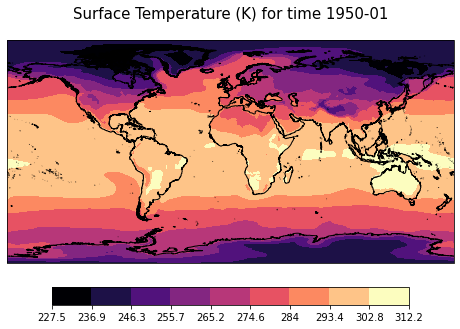

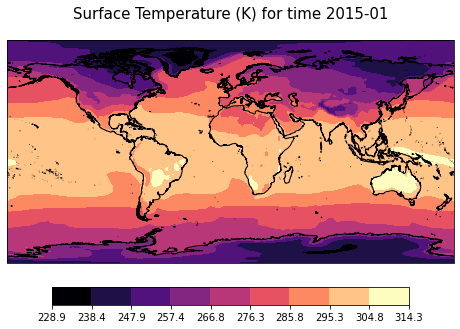

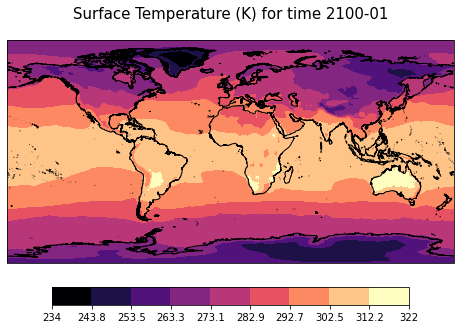

In [7]:
# Extracting the lat-lon coordinates for plotting (they are common to all files)
lat = get_data_from_file(file_var_1950_1999,'lat')[0]
lon = get_data_from_file(file_var_1950_1999,'lon')[0]

# Extracting the variable from the different files
var_1950_1999, time_1950_1999 = get_data_from_file(file_var_1950_1999, variable)
var_2000_2014, time_2000_2014 = get_data_from_file(file_var_2000_2014, variable)
var_2015_2064, time_2015_2064 = get_data_from_file(file_var_2015_2064, variable)
var_2065_2100, time_2065_2100 = get_data_from_file(file_var_2065_2100, variable)

# Concatenating variable and time DataArrays into one DataArray
var_1950_2100 = xr.concat([var_1950_1999,var_2000_2014,var_2015_2064,var_2065_2100], dim="time")
time_1950_2100 = xr.concat([time_1950_1999,time_2000_2014,time_2015_2064,time_2065_2100], dim="time")

# Displaying available start and end dates
print('Available range of years to display:', time_1950_1999.time[0].dt.year, ' to ', time_2065_2100.time[-1].dt.year)

# Defining beginning and end of historical and ssp runs
time_hist_init = '1950-01'
time_ssp_init  = '2015-01'
time_ssp_end   = '2100-01'

# Displaying some data
plot_timeslice(var_1950_2100,time_hist_init)   # Start of historical run
plot_timeslice(var_1950_2100,time_ssp_init)    # Start of ssp run
plot_timeslice(var_1950_2100,time_ssp_end)     # End of ssp run

# Example for plotting with common colorbar range. 
# vmin = 227
# vmax = 328
# plot_timeslice(var_1950_2100,time_hist_init, vmin=vmin, vmax=vmax)   # Start of historical run
# plot_timeslice(var_1950_2100,time_ssp_init, vmin=vmin, vmax=vmax)    # End of historical run
# plot_timeslice(var_1950_2100,time_ssp_end, vmin=vmin, vmax=vmax)     # End of ssp run

# # Example for plotting with fewer colorbar tick labels (handy when looking at precipitation). 
# cbar_tick=5
# vmin = 0
# vmax = 1e-4
# plot_timeslice(var_1950_2100,time_hist_init,vmin=vmin, vmax=vmax, cbar_tick=cbar_tick)   # Start of historical run
# plot_timeslice(var_1950_2100,time_hist_end,vmin=vmin, vmax=vmax, cbar_tick=cbar_tick)    # End of historical run
# plot_timeslice(var_1950_2100,time_ssp_end,vmin=vmin, vmax=vmax, cbar_tick=cbar_tick)     # End of ssp run

# Displaying the differences w.r.t the beginning of historical run

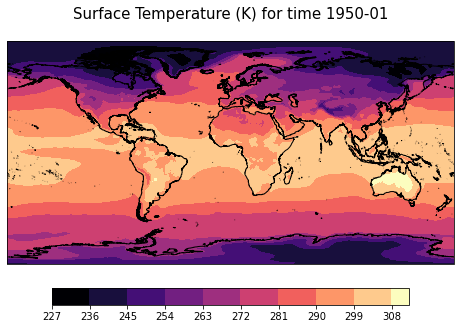

/glade/scratch/katec/ipykernel_22288/3526463685.py:169: RuntimeWarning: divide by zero encountered in log10
  exp = np.floor(np.log10(np.abs(entry[i])))


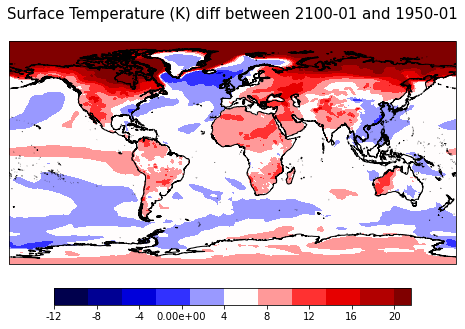

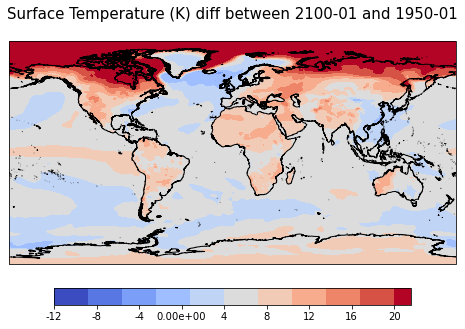

In [8]:
# Seting up the time array to consider
time_compare = [time_hist_init, time_ssp_end, time_ssp_end]
# time_compare = [time_hist_init, time_ssp_end]


# Plotting the differences
# plot_diff(var_1950_2100, time_compare)

# Example for plotting differences with common colorbar range. 
vmin=[227,-12]
vmax=[308,20]
cmaps = ['magma','seismic','coolwarm']
levels = [10,11]
cbar_tick = [10,9]

plot_diff(var_1950_2100, time_compare, vmin=vmin, vmax=vmax, cmap=cmaps, levels=levels, cbar_tick=cbar_tick)

# Displaying annual means

In this section, we will average the monthly output data into yearly averages. This means the time entry format will need to be modified (compared to the what we did for the raw output). After the averaging is done, we only need to specify the year we would like to display. For example, time = '1987' is the right format. 

There is a time dimension associated to the dataset, we can continue.
Number of years to average =  151


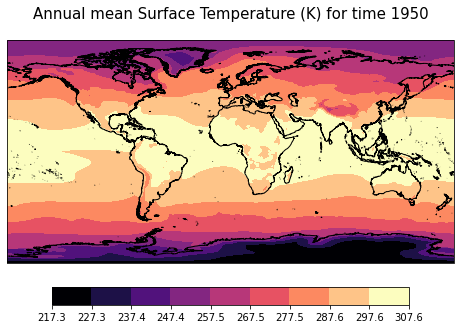

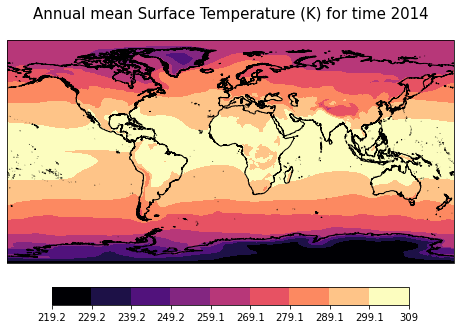

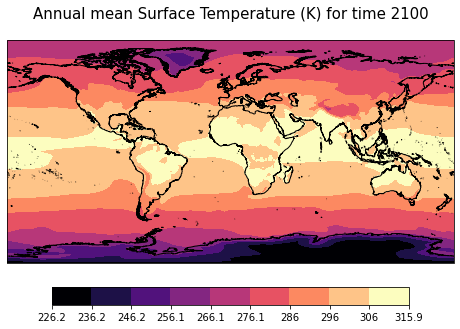

In [9]:
# Computing the annual mean of the variable
# Note: with this funcion, time_1950_2100_mean will only contain one entry per year!
var_1950_2100_annual_mean,time_1950_2100_mean = calc_annual_mean(var_1950_2100)

# Defining the times to display
time_hist_init_mean = '1950'
time_hist_end_mean  = '2014'
time_ssp_end_mean   = '2100'

# # Plotting the annual mean time slices
plot_timeslice(var_1950_2100_annual_mean,time_hist_init_mean)
plot_timeslice(var_1950_2100_annual_mean,time_hist_end_mean)
plot_timeslice(var_1950_2100_annual_mean,time_ssp_end_mean)

# Example for plotting the annual mean on the same colorbar range
# vmin = 217
# vmax = 307.1
# plot_timeslice(var_1950_2100_annual_mean,time_hist_init_mean, vmin=vmin, vmax=vmax)
# plot_timeslice(var_1950_2100_annual_mean,time_hist_end_mean, vmin=vmin, vmax=vmax)
# plot_timeslice(var_1950_2100_annual_mean,time_ssp_end_mean, vmin=vmin, vmax=vmax)

# Displaying diffrences in annual means

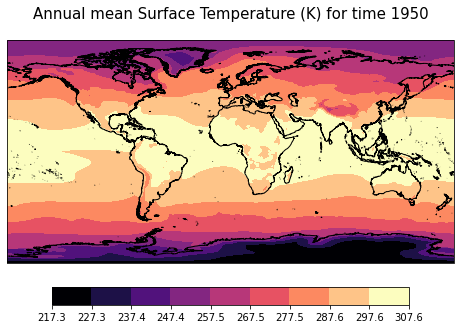

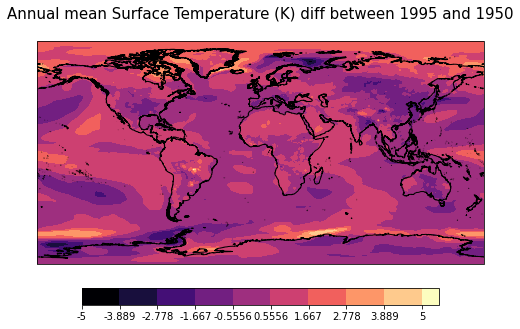

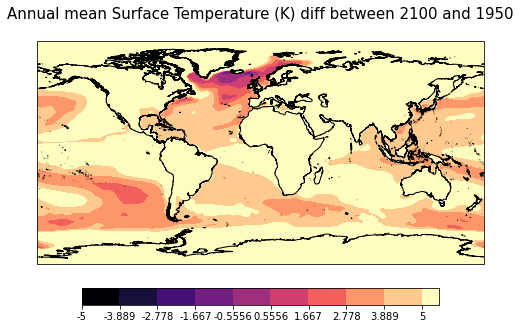

In [10]:
# Seting up the time array to consider
time_compare_mean = ['1950','1995','2100']

# Plotting the annual mean differences
plot_diff(var_1950_2100_annual_mean,time_compare_mean)

# # Plotting the annual mean differences with different colormaps
# cmap = ['viridis','YlGnBu','inferno']
# plot_diff(var_1950_2100_annual_mean,time_compare_mean, cmap=cmap)

# Creating time series of spatially averaged annual mean


In this section we will compute the spatial mean of the annual averages computed above in order to plot yearly time series. In order to do so we first compute the scaling weights to adjust the averages computation according to the polar stereographic projection grid used in CESM simulations. 

Text(0.5, 1.0, 'Annual spatially averaged Surface Temperature')

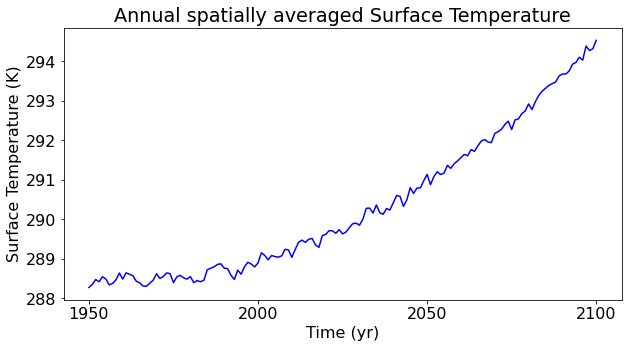

In [11]:
# Creating weight to account for polar grid cells distortion
weights = np.cos(np.deg2rad(lat))
weights.name = "weights"

# Adding the weights to the DataArray
var_1950_2100_annual_mean_weighted = var_1950_2100_annual_mean.weighted(weights)

# Computing the weighted average time series and adding attributes
var_tseries_weighted_mean = var_1950_2100_annual_mean_weighted.mean(("lat","lon"))
var_tseries_weighted_mean.attrs["long_name"] = "Annual spatially averaged " + var_1950_2100.attrs['long_name']
var_tseries_weighted_mean.attrs["units"] = var_1950_2100.attrs['units']

# Converting time entry from cftime._cftime.DatetimeNoLeap format to number array
time_mean = convert_time_entry(time_1950_2100_mean)[0]


# Some plotting parameters
color = 'blue'
label = None
line = '-'
y_label = '{0} ({1})'.format(var_1950_2100.attrs['long_name'], var_tseries_weighted_mean.attrs['units'])
tick_time = np.linspace(1950,2100,4)
title= '{0}'.format(var_tseries_weighted_mean.attrs['long_name'])

plt.figure(figsize=(10, 5))
plt.plot(time_mean, var_tseries_weighted_mean, line, ms=3, mfc=color, color=color, label=label)
plt.ylabel(y_label)
plt.xlabel('Time (yr)')
plt.xticks(tick_time)
plt.title(title)
